## train.py 和 predict.py 基于 Image Classifier Project-zh_v6.ipynb 进行修改

### train.py 使用说明：
---

1. 需将花卉文件夹 **flowers** 存放至 **train.py** 所在文件夹内
   * flowers 文件夹内有 train、valid、test 三个文件夹，分别是 102 类花卉的图片
---
2. 可训练并保存网络，并输出损失和正确率
---
3. 使用命令行 **python train.py flowers** 进行训练，默认参数如下：
   * 保存路径（save_dir）: 当前文件夹
   * 保存名称（save_name）：checkpoint
   * 模型（arch）：densenet121（可选 vgg16）
   * 学习率（learning_rate）：0.001
   * 使用 GPU 模式（gpu） ：否
   * 隐藏层单元数（hidden_layer）：512
   * 训练周期（epochs）：5
   
   例如：使用 GPU 模式，vgg16 模型的命令行应为 **python train.py flowers --gpu True --arch vgg16**（其他参数修改方式相同）

### predict.py 使用说明：
----
1. 可加载由 **train.py** 训练好的网络 (默认保存为当前文件夹下 checkpoint.pth)
---
2. 可根据输入（image_path），预测概率前 5（可自行设置） 的花卉名称及对应概率，若预测出的最大概率花卉名称与真实名称一致，则判定预测成功，否则失败
    * image_path 的格式应为：flowers/test/xxx/image_xxxxx.jpg
---
3. 预测输入图片的前 3 概率值及对应花卉名称的命令行应为：**python predict.py image_path checkpoint.pth --top_k 3**

### .pth 文件使用说明
* **densenet121.pth** 是用 densenet121 训练的保存点，可使用命令行 **python predict.py image_path densenet121.pth** 进行调用，以下.pth 文件调用方式相同
* **densenet121_1024.pth**  (隐藏层单元数为 1024 的 densenet121)
* **vgg16.pth**

### 以下基于训练好的网络模型，在 jupyter notebook 上加载并进行预测
  * 环境说明：README.ipynb 同级存放.pth 加载点以及 flowers 文件夹

In [31]:
# 导入必要的软件包和模块
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import os
from PIL import Image
import json
import seaborn as sb
import matplotlib.pyplot as plt

In [32]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [33]:
def load_model(pth='checkpoint.pth'):
    
    print('正在重构模型......')
    model_state = torch.load(pth)
    #model = models.vgg16(pretrained=True)
    model = models.densenet121(pretrained=True)
    
    print('正在传递分类器状态......')
    model.classifier = model_state['classifier']
    print('正在加载已训练好的参数......')
    model.load_state_dict(model_state['state_dict'])
    print('正在传递标签索引......')
    model.class_to_idx = model_state['class_to_idx']
    print('模型重构完毕！')
    
    return model

In [34]:
def predict(image_pth, model, topk=5):

    model.eval()
    model.cpu()
    
    image = process_image(image_pth) # Tensor
    model_input = image.unsqueeze(0)

    output = model(model_input)
    output_probs = F.softmax(output, dim=1)#将交叉熵输出归一化
    top_probs, top_labels = output_probs.topk(topk)

    top_probs = top_probs.detach().numpy().tolist()[0] 
    top_labels = top_labels.detach().numpy().tolist()[0]
    
    index_to_class = {model.class_to_idx[k]: k for k in model.class_to_idx}
    chosen_classes = []
    for label in top_labels:
        chosen_classes.append(index_to_class[label])

    return top_probs, chosen_classes

In [35]:
def process_image(image_pth):

    pil_image = Image.open(image_pth)
    data_transforms = transforms.Compose([                  #测试集
        transforms.Resize(256),
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    image = data_transforms(pil_image)

    return image

In [36]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()   
    if title:
        plt.title(title)

    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    
    return ax

In [37]:
def display_predict(image_pth):
    # 设置图像大小
    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    # 设置图像名称
    flower_num = image_pth.split('/')[2]
    title = cat_to_name[flower_num]
    #显示输入的图像
    img = process_image(image_pth)
    imshow(img, ax, title)
    
    # 进行预测
    probs, classes = predict(image_pth, model, topk=5) 
    flower_name = []
    for class_idx in classes:
        flower_name.append(cat_to_name[class_idx])
    # 画出概率分布
    plt.subplot(2,1,2)
    sb.barplot(x=probs, y=flower_name, color=sb.color_palette()[0])
    
    plt.show()

### 使用 densenet121 进行预测：

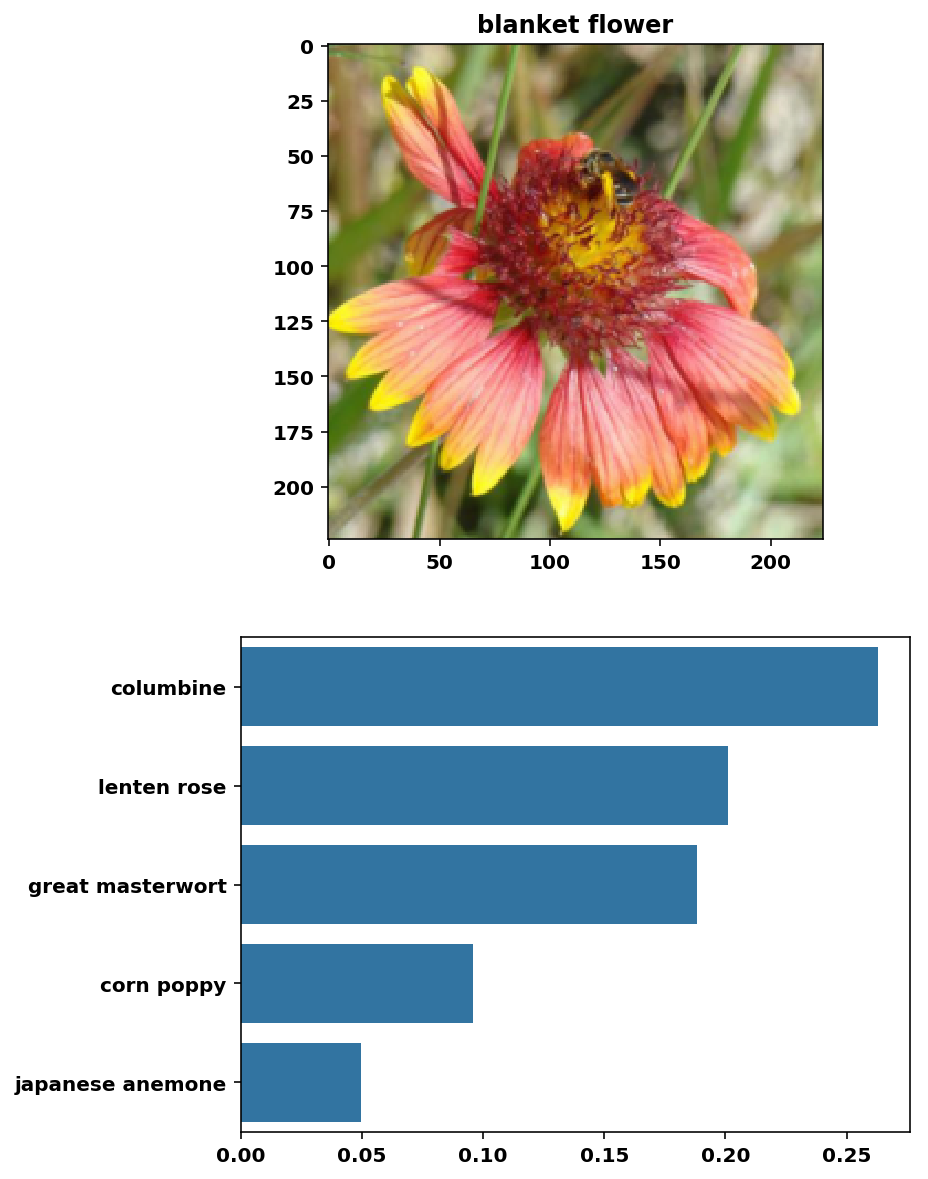

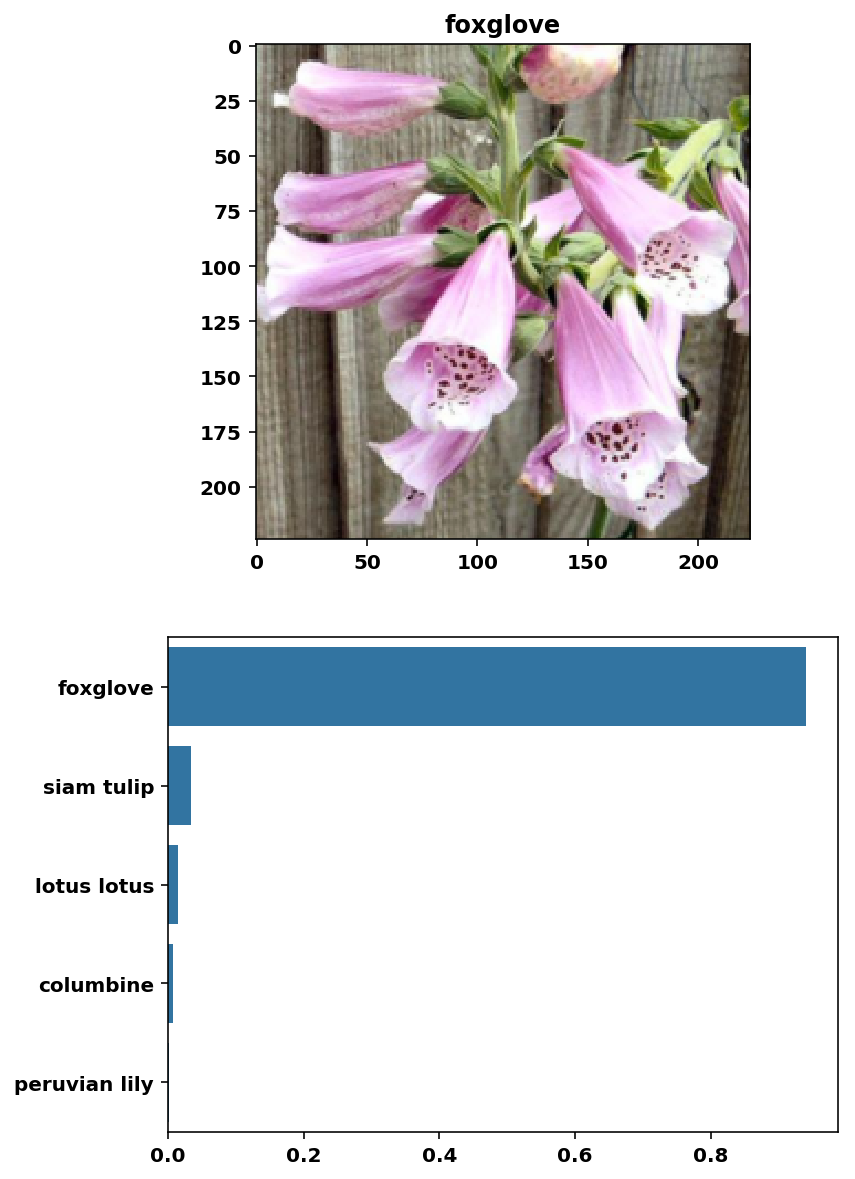

In [45]:
#model = load_model('densenet121.pth')
display_predict('flowers/test/100/image_07902.jpg')
display_predict('flowers/test/94/image_07399.jpg')

### 使用 densenet121（隐藏层单元数由 512 变为 1024） 进行预测：

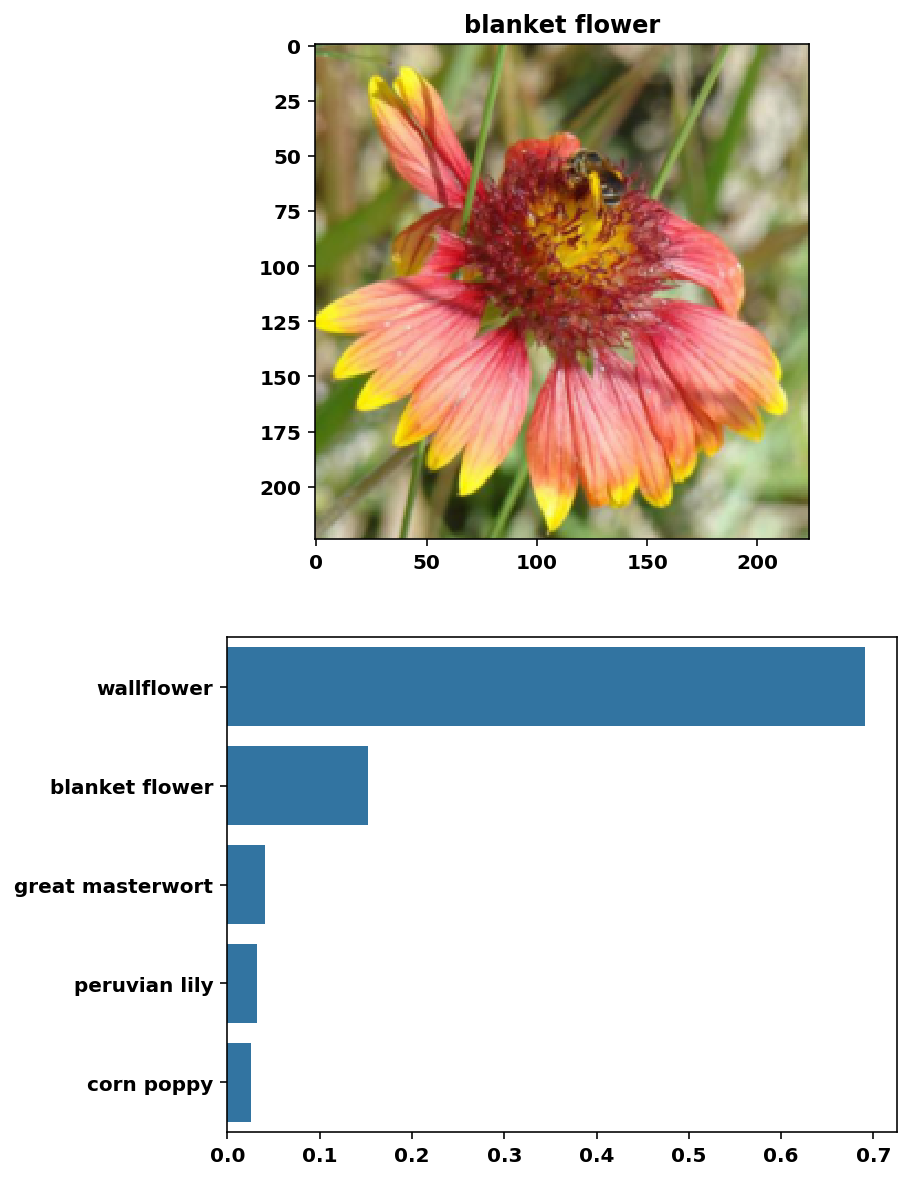

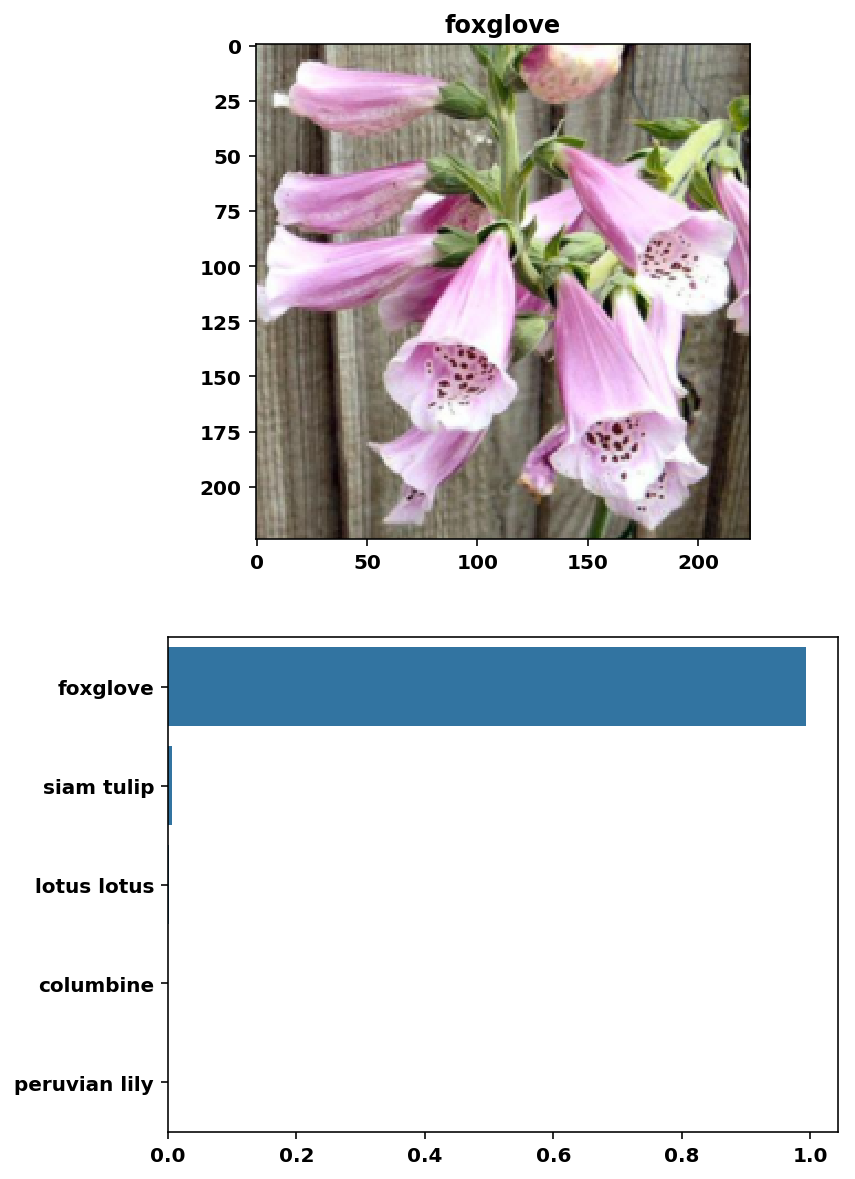

In [47]:
#model = load_model('densenet121_1024.pth')
display_predict('flowers/test/100/image_07902.jpg')
display_predict('flowers/test/94/image_07399.jpg')

### 使用 vgg16 进行预测：

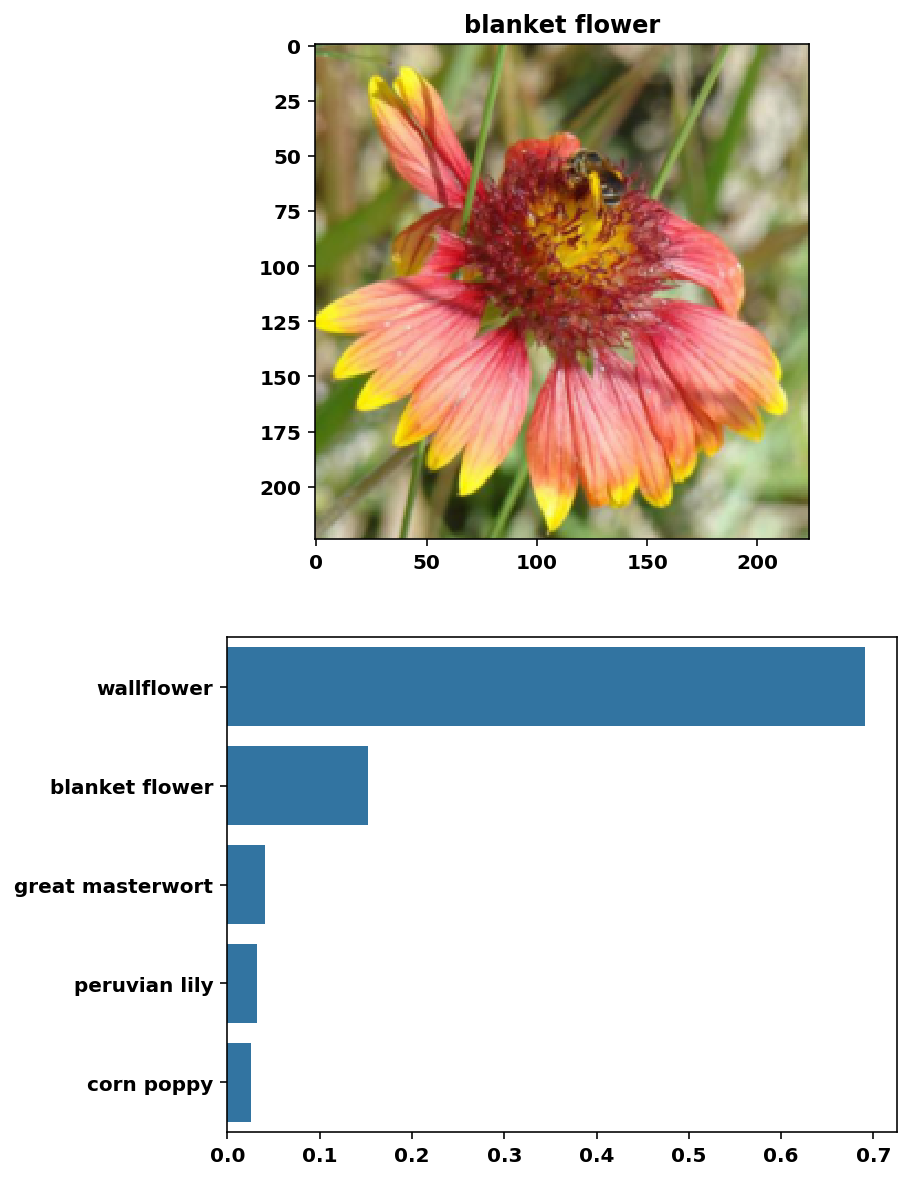

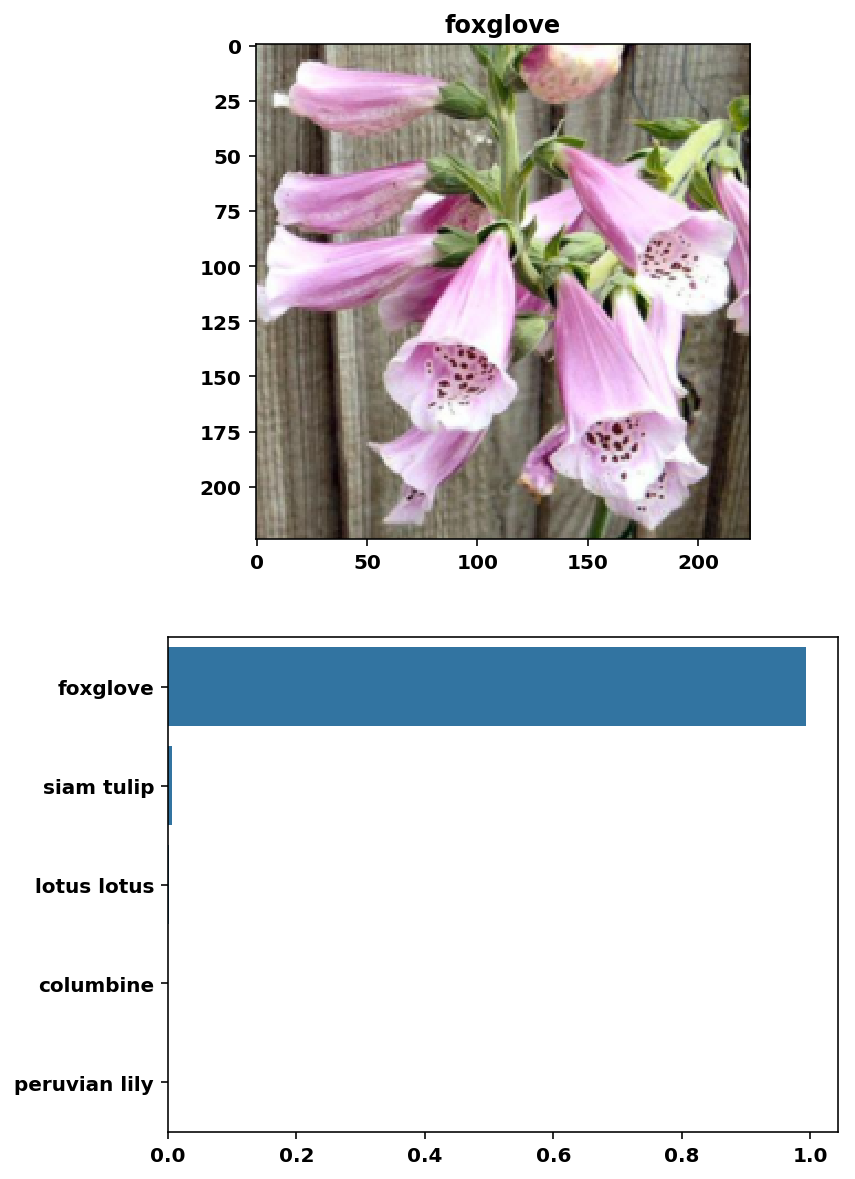

In [49]:
#model = load_model('vgg16.pth')
display_predict('flowers/test/100/image_07902.jpg')
display_predict('flowers/test/94/image_07399.jpg')

## 推断：

   * 每次训练，对同一张图片的识别准确率可能不同（Image Classifier Project-zh_v6.ipynb 中识别 blanket flower 以 67% 的概率成功预测，而在另一次训练则预测失败，上图可见）
   
   * 增加隐藏层单元数有提升模型性能的作用
   * 在同等默认参数（学习率、训练周期、隐藏层数、隐藏层单元数）下，vgg16 比 densenet121 模型预测更加准确（vgg16全连接层输入单元数为25088，densenet121则为1024）